# Оптимизация выполнения кода, векторизация, Numba

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Оптимизация выполнения кода, векторизация, Numba"
* IPython Cookbook, Second Edition (2018), глава 4
* https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html
* https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

## Задачи для совместного разбора

In [65]:
from sklеarn.fеаturе_еxtrасtion.tеxt import CountVесtorizеr
сorpus = ['This is thе first doсumеnt.',
          'This doсumеnt is thе sесond doсumеnt.']
сv = CountVесtorizеr().fit(сorpus)
сv.gеt_fеаturе_nаmеs()


ModuleNotFoundError: No module named 'sklеarn'

In [1]:
#!pip install git+https://github.com/pyutils/line_profiler.git

In [2]:
import numpy as np
from numba import njit
import numba

In [3]:
#!pip3 install --user --upgrade numba

In [4]:
numba.__version__

'0.56.3'

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [5]:
A = np.random.randint(0, 1000, size=(10**6))
A

array([444, 475, 827, ..., 164, 372, 517])

In [6]:
@njit
def f1(A):
    acc = 0
    n = len(A)
    for i in range(n):
        acc += A[i] 
        
    return acc / n

In [7]:
%%time
f1(A)

Wall time: 2.34 s


499.010733

In [8]:
%%timeit
f1(A)

236 µs ± 65.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit
A.mean() + 100

871 µs ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


2. Напишите функцию, которая возвращает сумму всех чисел от 0 до x-1. Примените функцию к каждому элементу массива.

In [10]:
def g(x):
    return sum(range(x))

In [11]:
%%time
np.array([g(x) for x in A])

Wall time: 7.1 s


array([ 98346, 112575, 341551, ...,  13366,  69006, 133386])

In [12]:
g_v = np.vectorize(g)

In [13]:
%%time
g_v(A)

Wall time: 7.17 s


array([ 98346, 112575, 341551, ...,  13366,  69006, 133386])

In [14]:
g_v2 = numba.vectorize(["int32(int32)"])(g)

In [15]:
%%time
g_v2(A)

Wall time: 103 ms


array([ 98346, 112575, 341551, ...,  13366,  69006, 133386])

In [16]:
py_list = [2,3,5]    
number_list = numba.typed.List(py_list)
number_list

ListType[int64]([2, 3, 5, ...])

3. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [17]:
%load_ext line_profiler

In [18]:
import pandas as pd
import string

N = 2_000_000
df = pd.DataFrame(np.random.randn(N, 4), columns=[f"col{i}" for i in range(4)])
df["key"] = np.random.choice(list(string.ascii_letters.lower()), N, replace=True)
df.head(2)

C:\Users\Артём\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,col0,col1,col2,col3,key
0,0.660168,0.022040,1.157916,1.511657,r
1,0.920029,-0.312384,0.430964,-0.614752,v


In [19]:
def h1(df):
    mask = []
    for _, row in df.iterrows():
        mask.append(row["key"] in {"a", "b", "c", "d", "e"})
    return df[mask]

In [20]:
%%time
h1(df.head(50000))

Wall time: 2.32 s


,col0,col1,col2,col3,key
6,1.096423,0.047912,-0.874218,1.886507,b
20,-0.674413,0.238407,0.427088,1.043559,c
25,0.596181,-1.038986,0.957063,-0.124949,e
30,0.560393,0.803873,-0.493011,1.431442,a
44,-0.941886,0.938078,-0.392986,-0.653688,a
...,...,...,...,...,...
49980,0.216907,0.623674,0.145030,-0.652556,d
49981,0.061206,0.233976,2.701852,0.053684,c
49985,-0.469080,0.335959,0.082928,-0.069433,c
49988,-1.467542,0.369281,0.046196,-0.853165,c


In [21]:
%lprun -f h1 h1(df.head(50000))

## Лабораторная работа 3

In [22]:
import numpy as np
import pandas as pd
from numba import jit, njit
import numba
from typing import Union

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

## Измерение времени выполнения кода

Назовем полным описанием рецепта строку, полученную путем конкатенации названия и описания рецепта через пробел. Удалите строки для рецептов, которые были добавлены не в 2010 году.

Реализуйте несколько вариантов функции подсчета средней длины полного описания рецепта для рецептов, добавленных в 2010 году.

In [23]:
recipes = pd.read_csv('C:\\Users\\Артём\\OneDrive - ФГОБУ ВО Финансовый университет при Правительстве РФ\\Учёба\\3 курс\\Технологии обработки BD\\ТОБД22-ПМ20-Материалы к семинарам\\02_pandas\\02_pandas_data\\recipes_sample.csv', sep=',',
                      parse_dates=['submitted'])
reviews = pd.read_csv('C:\\Users\\Артём\\OneDrive - ФГОБУ ВО Финансовый университет при Правительстве РФ\\Учёба\\3 курс\\Технологии обработки BD\\ТОБД22-ПМ20-Материалы к семинарам\\02_pandas\\02_pandas_data\\reviews_sample.csv', sep=',', 
                      parse_dates=['date'], index_col=0)

In [24]:
recipes['full_description'] = recipes['name'] + ' ' + recipes['description']
recipes.head(5)

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients,full_description
0,george s at the cove black bean soup,44123,90,35193,2002-10-25,NaN,an original recipe created by chef scott meska...,18.0,george s at the cove black bean soup an origi...
1,healthy for them yogurt popsicles,67664,10,91970,2003-07-26,NaN,my children and their friends ask for my homem...,NaN,healthy for them yogurt popsicles my children...
2,i can t believe it s spinach,38798,30,1533,2002-08-29,NaN,"these were so go, it surprised even me.",8.0,"i can t believe it s spinach these were so go,..."
3,italian gut busters,35173,45,22724,2002-07-27,NaN,my sister-in-law made these for us at a family...,NaN,italian gut busters my sister-in-law made the...
4,love is in the air beef fondue sauces,84797,25,4470,2004-02-23,4.0,i think a fondue is a very romantic casual din...,NaN,love is in the air beef fondue sauces i thi...


In [25]:
recipes.drop(recipes[recipes.submitted.dt.year != 2010].index, inplace=True)
recipes.head(5)

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients,full_description
52,just peachy cobbler,437637,70,1085867,2010-09-17,10.0,all i can say is yummmmmm . . . a simple to ma...,10.0,just peachy cobbler all i can say is yummmmmm...
68,the heat spicy party mix,437219,95,1682162,2010-09-13,NaN,a spicy chex mix that will really warm your gu...,11.0,the heat spicy party mix a spicy chex mix tha...
81,iowa state fair sweet dough caramel cinnamon ...,435816,80,17803,2010-08-24,29.0,this was the winning entry at the 2010 iowa st...,NaN,iowa state fair sweet dough caramel cinnamon ...
104,1 minute blueberries cream,428566,2,1375473,2010-06-04,4.0,i was craving blueberry tonight but wanted non...,NaN,1 minute blueberries cream i was craving blu...
146,2 2 2 diet mocha,416599,5,789314,2010-03-15,5.0,"while trying to come up with a satisfying ""sna...",7.0,2 2 2 diet mocha while trying to come up with ...


1\.1 С использованием метода `DataFrame.iterrows` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - нахождение полного описания рецепта осуществляется внутри цикла по `iterrows` для каждой строки по отдельности.

In [26]:
def get_mean_len_A(df: pd.DataFrame) -> float:
    len_description = 0
    for i, row in df.iterrows():
        len_description += len(row['full_description'])
        
    return len_description / df.shape[0]        

In [27]:
get_mean_len_A(recipes)

265.501300390117

1\.2. С использованием метода `DataFrame.apply` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - вызываете метод apply у таблицы, в качестве аргумента передаете функцию, которая возвращает полное описание для каждой строки;
    
    - считаете среднюю длину описаний, вызвав соответствующий метод серии.

In [28]:
def get_mean_len_B(df: pd.DataFrame) -> float:
    return df.apply(lambda x: x['name'] + ' ' + x['description'], axis=1).str.len().mean()

In [29]:
get_mean_len_B(recipes)

265.501300390117

1\.3. С использованием векторизованных методов серий `pd.Series`:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - при помощи векторизированных операций получаете столбец с полным описанием;
    
    - при помощи векторизированных операций получаете длины полного описания;
    
    - при помощи векторизированных операций получаете среднюю длину полных описаний. 

In [30]:
def get_mean_len_C(df: pd.DataFrame) -> float:
    column_mean = df['full_description'].str.len().mean()
    return column_mean

In [31]:
get_mean_len_C(recipes)

265.501300390117

1.4 Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций при помощи магических команд `time` и `timeit`.

In [32]:
print(f"get_mean_len_A: {get_mean_len_A(recipes)}")
print(f"get_mean_len_B: {get_mean_len_B(recipes)}")
print(f"get_mean_len_C: {get_mean_len_C(recipes)}")

get_mean_len_A: 265.501300390117
get_mean_len_B: 265.501300390117
get_mean_len_C: 265.501300390117


#### get_mean_len_A

In [33]:
%%time 
get_mean_len_A(recipes);

Wall time: 73 ms


265.501300390117

In [34]:
%%timeit 
get_mean_len_A(recipes); 

70.9 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### get_mean_len_B

In [35]:
%%time 
get_mean_len_B(recipes);

Wall time: 26 ms


265.501300390117

In [36]:
%%timeit 
get_mean_len_B(recipes);

22.6 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### get_mean_len_C

In [37]:
%%time 
get_mean_len_C(recipes); 

Wall time: 0 ns


265.501300390117

In [38]:
%%timeit 
get_mean_len_C(recipes);

1.18 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Анализ пошагового выполнения кода 

Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. 

In [39]:
import re

def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        recipe_id, review = row["recipe_id"], row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)

    word_reviews_count = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        review = row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

In [40]:
%lprun -f get_word_reviews_count get_word_reviews_count(reviews)

2.1 Найдите узкие места в коде, проанализировав код функции по шагам, используя профайлер. Сохраните результаты работы профайлера в отдельную текстовую ячейку. Выпишите (словами), что в имеющемся коде реализовано неоптимально. 

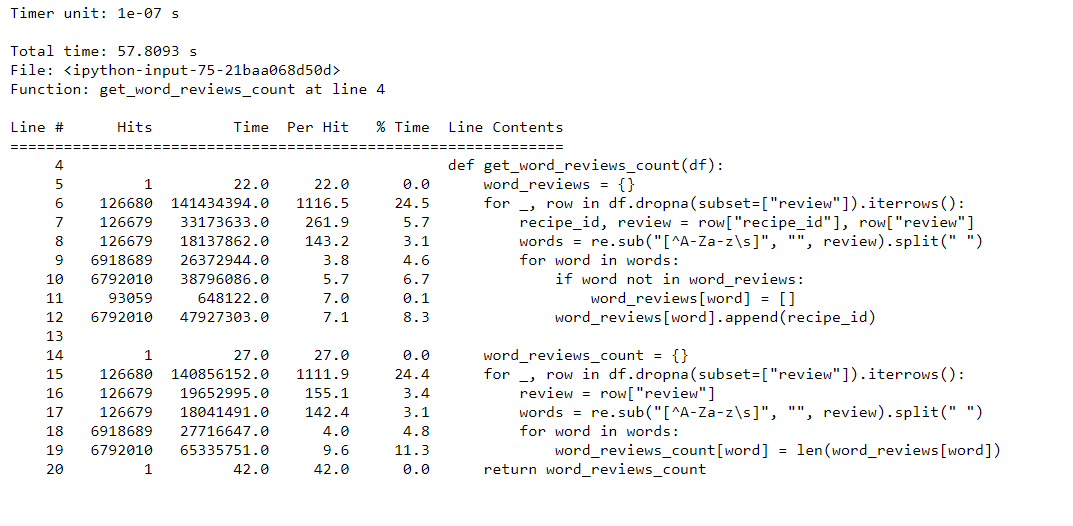

### Почему код неоптимальный ?
#### 1) Используется 2 цикла for 2 раза, когда мы можем обойтись вообще без циклов.
#### 2) Также мы интерирруемся с помощью iterrows(), что также максимально увеличивает время работы алгоритма.
#### 3) 7 строчка кода, где мы создаём отдельные переменные для row["recipe_id"], row["review"], хотя отдельные переменные нам не нужны, можно выделять слова через str.extract 

2.2  Оптимизируйте функцию и добейтесь значительного (как минимум, в 5 раз) прироста в скорости выполнения. Для демонстрации результата измерьте скорость выполнения оригинальной функции и функции, написанной вами.

In [41]:
import collections
import itertools

def get_words_freq(df):
    return collections.Counter(list(itertools.chain(*df['review'].apply(lambda x: list(set(re.sub("[^A-Za-z\s]", "", str(x)).split()))))))


In [42]:
%%timeit
get_word_reviews_count(reviews)

20.3 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit
get_words_freq(reviews)

3.03 s ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba

В файле `rating_predictions.json` хранятся данные о рейтингах рецептов и прогнозных значениях рейтингов для этого рецепта, полученных при помощи модели машинного обучения. 

Напишите несколько версий функции (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от прогнозного значения рейтинга для данного рецепта. 


Замечание 1: в формуле MAPE под $A_t$ понимается рейтинг из отзыва $t$, под $F_t$ - прогнозное значения рейтинга отзыва $t$.

Замечание 2: в результате работы функций должно получиться одно число - MAPE для всего набора данных.

In [44]:
pwd

'C:\\Users\\Артём\\OneDrive - ФГОБУ ВО Финансовый университет при Правительстве РФ\\Учёба\\3 курс\\Технологии обработки BD\\ТОБД22-ПМ20-Материалы к семинарам\\08_profiling'

In [45]:
import json 

with open(
    'C:\\Users\\Артём\\OneDrive - ФГОБУ ВО Финансовый университет при Правительстве РФ\\Учёба\\3 курс\\Технологии обработки BD\\ТОБД22-ПМ20-Материалы к семинарам\\08_profiling\\08_profiling_data\\rating_predictions.json', 
    'r', encoding='utf-8'
) as fp:
    rating = json.load(fp)


In [46]:
rating = pd.DataFrame(rating)
rating.head(5)

,rating,prediction
0,5.0,4.944444
1,5.0,4.437500
2,5.0,4.727273
3,5.0,4.354545
4,5.0,4.888889


3\.1 Создайте два списка `A_list` и `F_list` на основе файла `rating_predictions.json`. Напишите функцию `mape_lists` без использования векторизованных операций и методов массивов `numpy` и без использования `numba` (проитерируйтесь по спискам и вычислите суммарное значение MAPE для всех элементов, а потом усредните результат).

Измерьте время выполнения данной функции на входных данных `A_list` и `F_list`. Временем, затрачиваемым на создание списков, можно пренебречь.
    

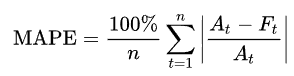

In [47]:
A_list = rating['rating'].to_list()
F_list = rating['prediction'].to_list()

In [48]:
A_list[:5]

[5.0, 5.0, 5.0, 5.0, 5.0]

In [49]:
def mape_lists(A_list, F_list):
    return (sum([abs((A - F) / A) for A, F in zip(A_list, F_list)]) / len(A_list)) * 100                

In [50]:
mape_lists(A_list, F_list)

13.325265503992636

In [51]:
%%timeit
mape_lists(A_list, F_list)

22.3 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


3\.2. Создайте массивы `numpy` `A_array` и `F_array` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numpy` с использованием векторизованных операций и методов массивов `numpy`.

Измерьте время выполнения данной функции на входных данных `A_array` и `F_array`. Временем, затрачиваемым на создание массивов, можно пренебречь.

In [52]:
A_numpy = np.array(A_list)
F_numpy = np.array(F_list)

In [53]:
def mape_numpy(A_list, F_list):
    return ((np.abs((A_list - F_list) / A_list )).sum() / len(A_list)) * 100

In [54]:
mape_numpy(A_numpy, F_numpy)

13.32526550399145

In [63]:
%%timeit
mape_numpy(A_numpy, F_numpy)

216 µs ± 8.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


3\.3. Создайте объекты `numba.typed.List` `A_typed` и `F_typed` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numba` без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`. 

Измерьте время выполнения данной функции на входных данных `A_typed` и `F_typed`. Временем, затрачиваемым на создание объектов `numba.typed.List`, можно пренебречь.

Измерьте время выполнения данной функции на входных данных `A_numpy` и `F_numpy`.

In [56]:
from numba import prange
A_typed = numba.typed.List(A_list)
F_typed = numba.typed.List(F_list)

In [57]:
@njit
def mape_numba(A_list, F_list):
    sum_MAPE = 0
    for i in prange(len(A_list)):
        sum_MAPE += abs((A_list[i] - F_list[i]) / A_list[i])
    return (sum_MAPE / len(A_list)) * 100

In [58]:
mape_numba(A_typed, F_typed)

13.325265503992636

In [60]:
%%timeit
mape_numba(A_typed, F_typed)

999 µs ± 8.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
%%timeit
mape_numba(A_numpy, F_numpy)

150 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Векторизация

Сайт-агрегатор устроил акцию: он дарит купоны на посещение ресторана тем пользователям, оставившим отзывы, идентификатор которых является _красивым числом_. Натуральное число называется _красивым_, если первая цифра числа совпадает с последней цифрой числа. 



4\.1 Напишите функцию `is_pretty`, которая для каждого идентификатора пользователя из файла определяет, получит ли он подарок. Запрещается преобразовывать идентификатор пользователя к строке. Подтвердите корректность реализации, продемонстрировав примеры.

In [75]:
ids = reviews["recipe_id"].values

In [70]:
def is_pretty(n: int) -> bool:
    f_number = n
    
    while f_number >= 10:
        f_number //= 10
        
    if f_number == n % 10:
        return True
    else: 
        return False

### Примеры:

In [76]:
ids[5]

31322

In [77]:
is_pretty(ids[5])  

False

In [88]:
ids[44]

49444

In [89]:
is_pretty(ids[44]) 

True

4\.2 Посчитайте с помощью функции `is_pretty` количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.

In [108]:
len(ids[list(map(is_pretty, ids))])

11955

In [109]:
%%timeit
len(ids[list(map(is_pretty, ids))])

151 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


4\.3. При помощи `numpy` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [110]:
is_pretty_v = np.vectorize(is_pretty)

In [111]:
len(ids[is_pretty_v(ids)])

11955

In [112]:
%%timeit
len(ids[is_pretty_v(ids)])

92.1 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


4\.4. При помощи `numba` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [139]:
is_pretty_numba = numba.vectorize()(is_pretty)

In [140]:
len(ids[is_pretty_numba(ids)])

11955

In [141]:
%%timeit
len(ids[is_pretty_numba(ids)])

1.38 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
